Моделируемое уравнение: $\dot{\phi}_j = \displaystyle\frac{\mu}{2} \Big[ \omega_j + \displaystyle\frac{d}{R_j}\sum_{k=1}^N{R_k(\sin(\phi_k-\phi_j-\gamma))} \Big], \quad j\neq k$


In [1]:
import numpy as np
from scipy.integrate import odeint
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from numba import jit
from pprint import pprint
import networkx as nx

# np.set_printoptions(threshold=np.inf)

In [2]:
# Параметры системы
N = 128
mu = 0.1
d = 0.3
gamma = np.pi/4

'''
omega = np.ones(N)
R = np.ones((N, N))
np.fill_diagonal(R, 0)  
'''

omega = np.random.rand(N)
R = np.random.rand(N, N)
np.fill_diagonal(R, 0)      # значения на диагонали равны 0
R = 0.5 * (R + R.T)         # делаем матрицу R симметричной

In [3]:
print('omega:')
pprint(omega)
print('------------\n')

print('R:')
pprint(R)
print('------------\n')

omega:
array([0.10208643, 0.98620164, 0.64189882, 0.82698531, 0.21154765,
       0.25359485, 0.1863361 , 0.03563756, 0.46997741, 0.37767013,
       0.12181075, 0.12793038, 0.93855593, 0.00314883, 0.22200012,
       0.84434126, 0.46042798, 0.39919309, 0.73415364, 0.55132397,
       0.17078428, 0.30572033, 0.82016882, 0.30910028, 0.12074263,
       0.52033729, 0.95852908, 0.37068925, 0.18851246, 0.03486758,
       0.77464903, 0.36543761, 0.65936606, 0.2101703 , 0.23288865,
       0.12436605, 0.5909909 , 0.66598848, 0.13053646, 0.09641486,
       0.02213423, 0.84146784, 0.42739667, 0.50757555, 0.68460869,
       0.32437455, 0.61487762, 0.83065515, 0.47547642, 0.3173927 ,
       0.97051475, 0.0349567 , 0.93812005, 0.02920976, 0.66987251,
       0.06387346, 0.53561192, 0.48574185, 0.3970504 , 0.47692115,
       0.49329943, 0.98713953, 0.24626021, 0.05007948, 0.50442982,
       0.05898806, 0.26600882, 0.46138066, 0.93407443, 0.11571625,
       0.2707776 , 0.28537529, 0.2865169 , 0.56466398, 

## Граф

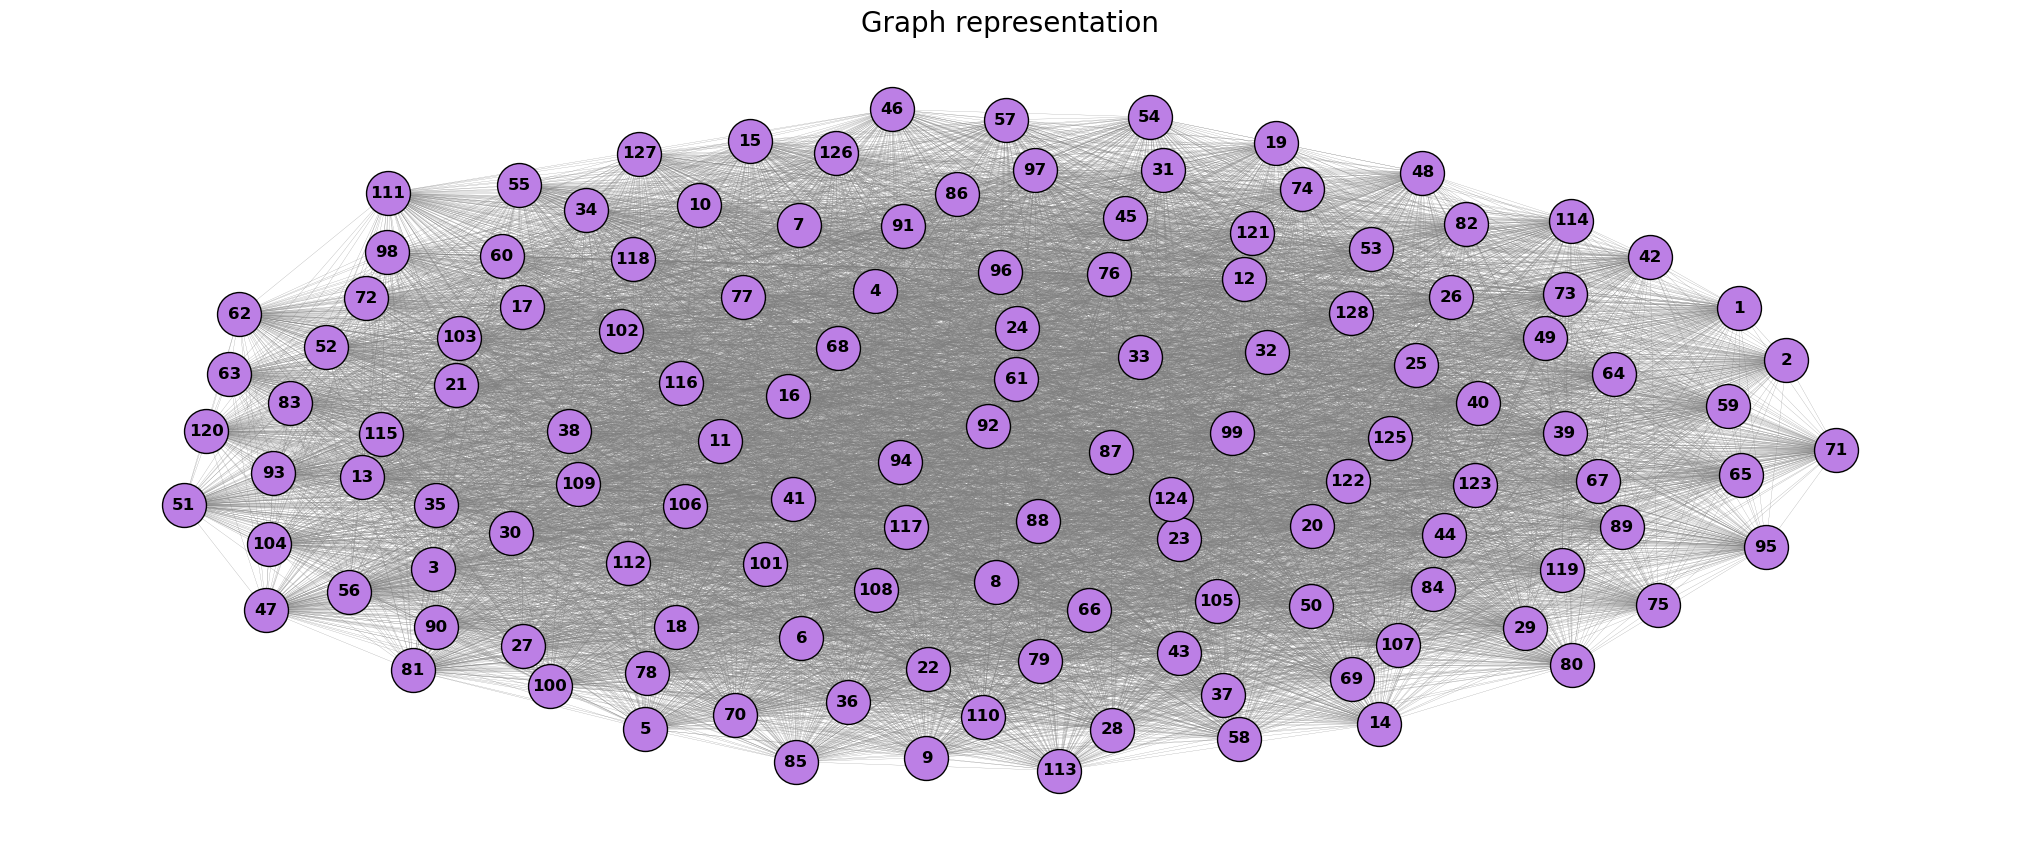

In [4]:
# Создание графа
G = nx.Graph()

# Добавление узлов в граф (начиная с 1)
for i in range(1, N + 1):
    G.add_node(i, label=f'Node {i}')

# Добавление рёбер в граф (используем теперь i и j с 1 по N)
for i in range(1, N + 1):
    for j in range(i + 1, N + 1):
        G.add_edge(i, j, weight=R[i-1, j-1])


# Отображение графа
pos = nx.spring_layout(G, k=0.9)
plt.figure(figsize=(20, 8))
nx.draw(G, pos, node_color='#bc7fe5', node_size=1_000, edge_color='grey',
        edgecolors='black', width=0.15, with_labels=True, font_weight='bold')

plt.title('Graph representation', size=20)
plt.show()

## Система

In [5]:
result = np.zeros(N)


@jit(nopython=True)
def system(phi, t, N, mu, omega, gamma, d, R):
    result = np.zeros(N)

    for j in range(N):
        summation = 0
        for k in range(N):
            # первое - есть ли связь, второе - сами с собой осц не связаны
            if (R[j, k] != 0) and (j != k):
                summation += R[j, k] * np.sin(phi[k] - phi[j] - gamma)
        if j + 1 <= N - 1:
            result[j] = mu / 2 * (omega[j] + d / R[j + 1, j] * summation)
        else:
            if R[0, j] != 0:   # будет 0 только когда связи произвольно заданы
                result[j] = mu / 2 * (omega[j] + d / R[0, j] * summation)
            else:
                result[j] = mu / 2 * omega[j]

    return result


phi0 = 2 * np.pi * np.random.rand(N)

t_span = np.linspace(0, 1000, 1000)

solution = odeint(system, phi0, t_span, args=(N, mu, omega, gamma, d, R))

# приведение к [0, 2пи]
solution = np.fmod(solution, 2*np.pi)
# 0 и 2пи на окружности одна точка
solution[solution == 2*np.pi] -= 2*np.pi
# отрицательные привели к [0, 2пи]
solution[solution < 0] += 2*np.pi

#pprint(solution)

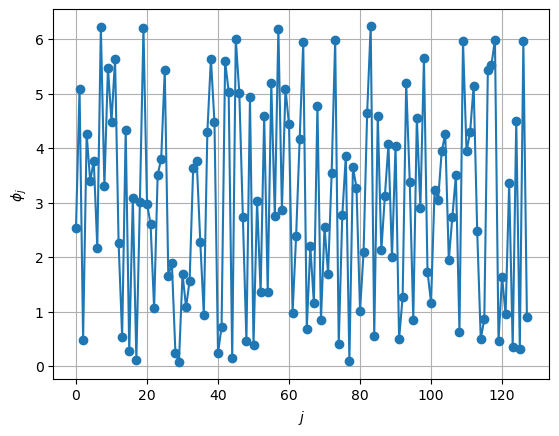

In [6]:
# начальное распределение
# Построение графика фазы от номера осциллятора
plt.plot(np.arange(N), phi0 , marker='o')
plt.xlabel('$j$')
plt.ylabel('$\phi_j$')
plt.grid(True)
plt.show()

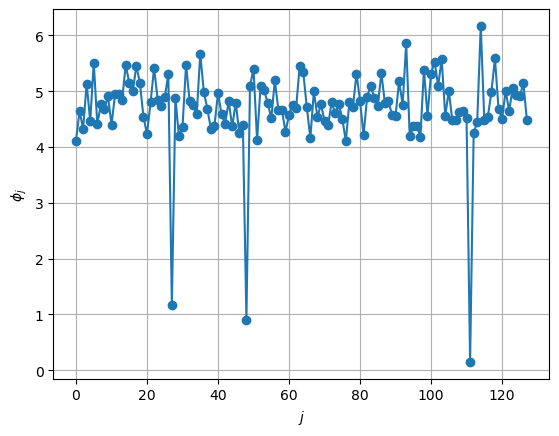

In [7]:
# финальное распределение
#plt.figure(figsize=(6, 4))

plt.plot(range(N), solution[-1,:], marker='o')
plt.xlabel('$j$')
plt.ylabel('$\phi_j$')
#plt.xticks(range(N))
plt.grid(True)
plt.show()

## Параметры порядка:

$R_1=\displaystyle \frac{1}{N}\Big|\sum^N_{j=1}e^{i\phi_j}\Big|$

$R_2=\displaystyle \frac{1}{N}\Big|\sum^N_{j=1}e^{2i\phi_j}\Big|$

Final values of R1 and R2:
R1: 0.8871667070542468
R2: 0.706164614220236


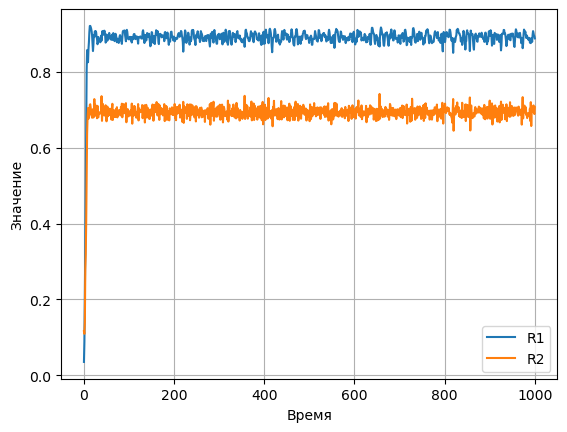

In [8]:
R1 = np.abs(np.mean(np.exp(1j * solution[:, :]), axis=1))
R2 = np.abs(np.mean(np.exp(2j * solution[:, :]), axis=1))

print("Final values of R1 and R2:")
print(f"R1: {R1[-1]}")
print(f"R2: {R2[-1]}")

with open("R1.txt", "a") as file:
    # Записать данные в файл
    file.write(f"{R1[-1]}\n")
with open("R2.txt", "a") as file:
    # Записать данные в файл
    file.write(f"{R2[-1]}\n")
    
# Построение графиков параметров порядка
plt.plot(t_span, R1, label='R1')
plt.plot(t_span, R2, label='R2')
plt.grid(True)
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

## Пространственно-временная диаграмма

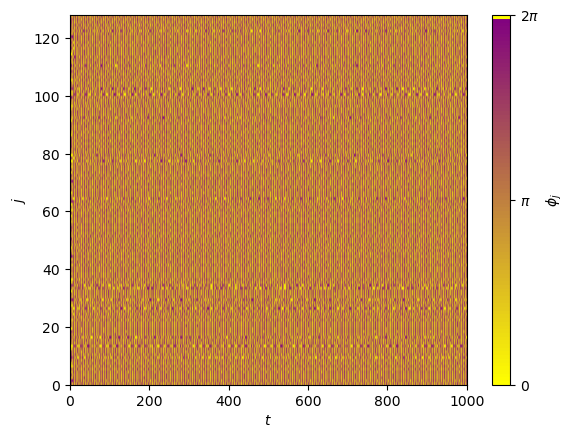

In [9]:
# Создание цветовой карты
colors = ['#FFFF00', '#800080']
n_bins = 100  # Количество оттенков

# 0 и 2*pi одним цветом
color_map_values = np.linspace([1, 1, 0], [128/255, 0, 128/255], n_bins)
color_map_values[0, :] = color_map_values[-1, :] = [1, 1, 0]

cmap_name = "custom_gradient"
custom_cmap = ListedColormap(color_map_values)

# Построение пространственно-временной диаграммы с градиентом цветовой карты
fig, ax = plt.subplots()
im = ax.imshow(solution.T, aspect='auto', cmap=custom_cmap, extent=[
               t_span[0], t_span[-1], 0, N], vmin=0, vmax=2*np.pi)
cb = plt.colorbar(im, ax=ax, label=fr'$\phi_j$', ticks=[0, np.pi, 2*np.pi])
cb.set_ticklabels(['$0$', '$\pi$', '$2\pi$'])

plt.xlabel(fr'$t$')
plt.ylabel(fr'$j$')
plt.show()

## Распределение осцилляторов

final time

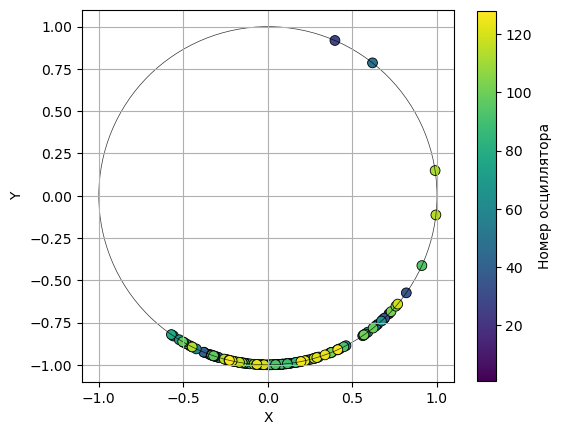

In [10]:
theta = solution[-1, :]

x = np.cos(theta)
y = np.sin(theta)

fig, ax = plt.subplots(figsize=(6, 6))
sc = ax.scatter(x, y, c=range(1, N+1), cmap='viridis',
                s=50, edgecolor='black', linewidth=0.6)
ax.set_aspect('equal', 'box')

circle = plt.Circle((0, 0), 1, color='black',
                    fill=False, linewidth=0.5, alpha=0.8)
ax.add_patch(circle)
ax.grid()

cbar = plt.colorbar(sc, shrink=0.8)
cbar.set_label('Номер осциллятора')

ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.show()